# Dataset Overview & Metadata Audit

5,880 images of 56 people over 5 head poses and 21 gaze directions

The data set contains a total of 5,880 high-resolution images of 56 subjects (32 male, 24 female), and each image has a resolution of 5,184 x 3,456 pixels. 21 of its subjects are Asian, 19 are White, 8 are South Asian, 7 are Black, and 4 are Hispanic or Latino. Its subjects range from 18 to 36 years of age, and 21 of them wear prescription glasses.


The data set includes images for each combination of five horizontal head poses (0°, ±15°, ±30°), seven horizontal gaze directions (0°, ±5°, ±10°, ±15°), and three vertical gaze directions (0°, ±10°) for each subject. This means that we collected five gaze locking images (0° vertical and horizontal gaze direction) for each subject: one for each head pose.

In [1]:
from pathlib import Path
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
DATA_ROOT = Path("~/Documents/00_210/data/columbia_gaze_dataset").expanduser()

rows = []

# Regex for filename parsing
pattern = re.compile(
    r"(?P<subject>\d+)_"
    r"(?P<distance>\d+)m_"
    r"(?P<head_pose>-?\d+)P_"
    r"(?P<gaze_v>-?\d+)V_"
    r"(?P<gaze_h>-?\d+)H\.jpg"
)

for subject_dir in DATA_ROOT.iterdir():
    if not subject_dir.is_dir():
        continue

    for img_path in subject_dir.glob("*.jpg"):
        match = pattern.match(img_path.name)
        if not match:
            continue  # skip unexpected filenames

        meta = match.groupdict()

        rows.append({
            "path": str(img_path),
            "filename": img_path.name,
            "subject": meta["subject"],
            "distance_m": int(meta["distance"]),
            "head_pose_deg": int(meta["head_pose"]),
            "gaze_vertical_deg": int(meta["gaze_v"]),
            "gaze_horizontal_deg": int(meta["gaze_h"]),
        })

df = pd.DataFrame(rows)


In [3]:
df.shape

(5880, 7)

In [4]:
df.head()

,path,filename,subject,distance_m,head_pose_deg,gaze_vertical_deg,gaze_horizontal_deg
0,/Users/cekr/Documents/00_210/data/columbia_gaz...,0050_2m_-30P_0V_-10H.jpg,0050,2,-30,0,-10
1,/Users/cekr/Documents/00_210/data/columbia_gaz...,0050_2m_30P_-10V_-5H.jpg,0050,2,30,-10,-5
2,/Users/cekr/Documents/00_210/data/columbia_gaz...,0050_2m_30P_-10V_5H.jpg,0050,2,30,-10,5
3,/Users/cekr/Documents/00_210/data/columbia_gaz...,0050_2m_-15P_10V_-10H.jpg,0050,2,-15,10,-10
4,/Users/cekr/Documents/00_210/data/columbia_gaz...,0050_2m_-15P_0V_5H.jpg,0050,2,-15,0,5


In [5]:
df['gaze_vertical_deg'].value_counts()

gaze_vertical_deg
 0     1960
-10    1960
 10    1960
Name: count, dtype: int64

In [6]:
df['gaze_horizontal_deg'].value_counts()

gaze_horizontal_deg
-10    840
-5     840
 5     840
 10    840
 15    840
-15    840
 0     840
Name: count, dtype: int64

In [7]:
def create_labels(row):
    '''
    converts per-image gaze metadata into an intent-level
    classification
    '''
    h = row["gaze_horizontal_deg"]
    v = row["gaze_vertical_deg"]

    # straight
    if v==0 and h==0: 
        return "straight"
    
    # horizontal dominates
    if abs(h) > abs(v):
        return "left" if h < 0 else "right"

    # vertical dominates
    if abs(v) > abs(h):
        return "down" if v < 0 else "up"

    # tie → horizontal wins (gaze is steadier in horizontal axis)
    return "left" if h < 0 else "right"

df["label"] = df.apply(create_labels, axis=1)


In [8]:
df.head()

,path,filename,subject,distance_m,head_pose_deg,gaze_vertical_deg,gaze_horizontal_deg,label
0,/Users/cekr/Documents/00_210/data/columbia_gaz...,0050_2m_-30P_0V_-10H.jpg,0050,2,-30,0,-10,left
1,/Users/cekr/Documents/00_210/data/columbia_gaz...,0050_2m_30P_-10V_-5H.jpg,0050,2,30,-10,-5,down
2,/Users/cekr/Documents/00_210/data/columbia_gaz...,0050_2m_30P_-10V_5H.jpg,0050,2,30,-10,5,down
3,/Users/cekr/Documents/00_210/data/columbia_gaz...,0050_2m_-15P_10V_-10H.jpg,0050,2,-15,10,-10,left
4,/Users/cekr/Documents/00_210/data/columbia_gaz...,0050_2m_-15P_0V_5H.jpg,0050,2,-15,0,5,right


In [9]:
# check class balance
df['label'].value_counts()

label
left        1960
right       1960
down         840
up           840
straight     280
Name: count, dtype: int64

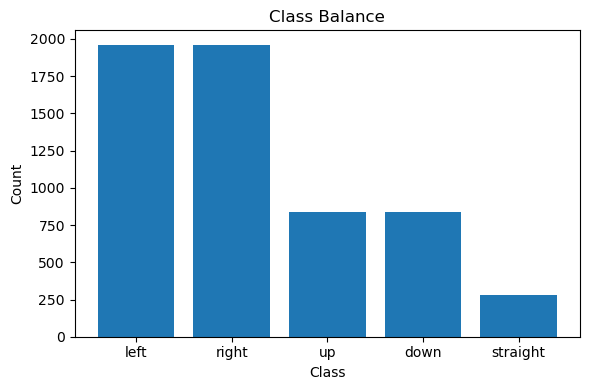

In [10]:
# compute class counts
counts = df["label"].value_counts().reindex(
    ["left", "right", "up", "down", "straight"]
)

# bar chart
plt.figure(figsize=(6, 4))
plt.bar(counts.index, counts.values)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Balance")
plt.tight_layout()
plt.show()

In [11]:
counts_by_subject = (
    df.groupby(["subject", "label"])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=["left", "right", "up", "down", "straight"])
)

counts_by_subject.head()

label,left,right,up,down,straight
subject,,,,,
0001,35,35,15,15,5
0002,35,35,15,15,5
0003,35,35,15,15,5
0004,35,35,15,15,5
0005,35,35,15,15,5


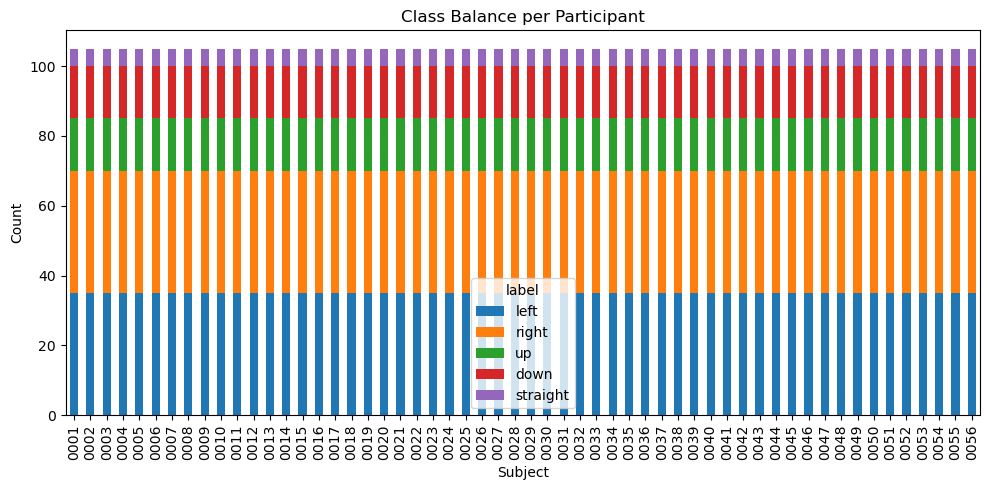

In [12]:
counts_by_subject.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 5)
)
plt.xlabel("Subject")
plt.ylabel("Count")
plt.title("Class Balance per Participant")
plt.tight_layout()
plt.show()

img shape: (3456, 5184, 3)
img shape: (3456, 5184, 3)
img shape: (3456, 5184, 3)
img shape: (3456, 5184, 3)
img shape: (3456, 5184, 3)


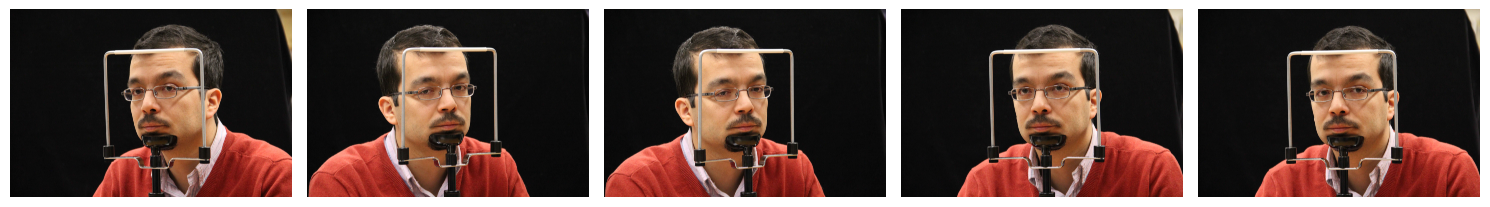

In [14]:
fig, axes = plt.subplots(1,5, figsize=(15, 4))

for i, ax in enumerate(axes):
    img = plt.imread(df.loc[i, "path"])
    print(f'img shape: {img.shape}')
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [24]:
df.dtypes

path                   object
filename               object
subject                object
distance_m              int64
head_pose_deg           int64
gaze_vertical_deg       int64
gaze_horizontal_deg     int64
label                  object
dtype: object

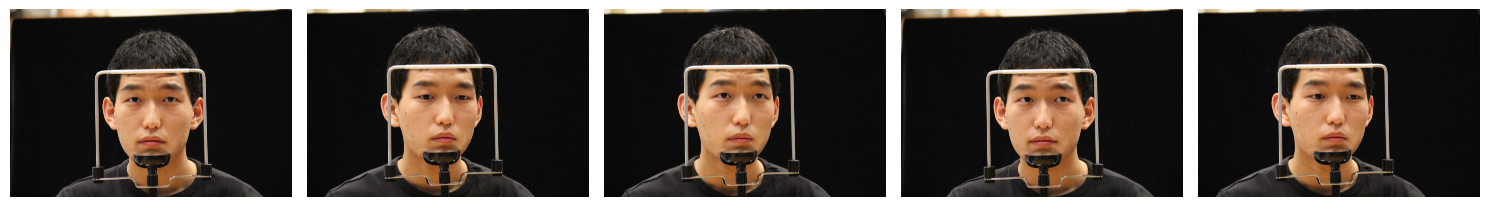

In [26]:
df_subj30 = df[df['subject']=='0030'].reset_index(drop=True)

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i, ax in enumerate(axes):
    img = plt.imread(df_subj30.loc[i, "path"])
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

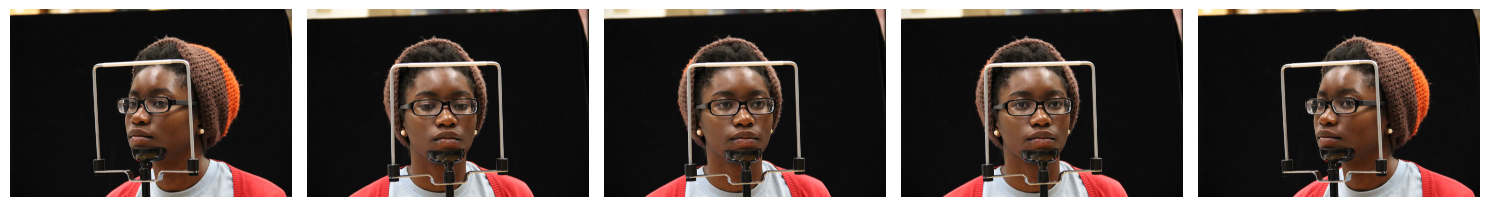

In [77]:
df_subj39 = df[df['subject']=='0039'].reset_index(drop=True)

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i, ax in enumerate(axes):
    img = plt.imread(df_subj39.loc[i, "path"])
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

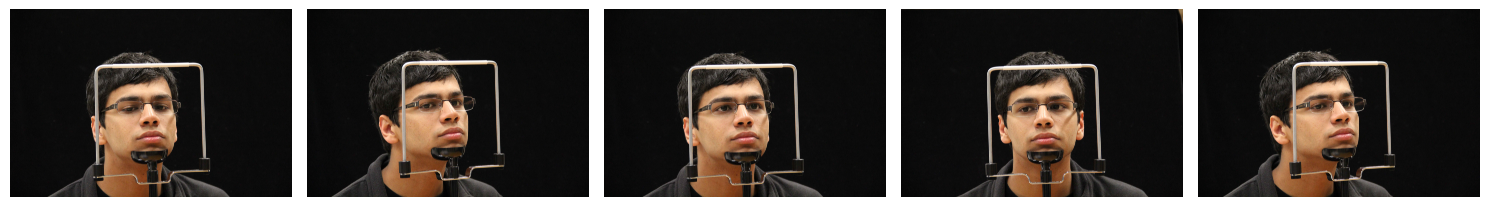

In [83]:
df_subj38 = df[df['subject']=='0034'].reset_index(drop=True)

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i, ax in enumerate(axes):
    img = plt.imread(df_subj38.loc[i, "path"])
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

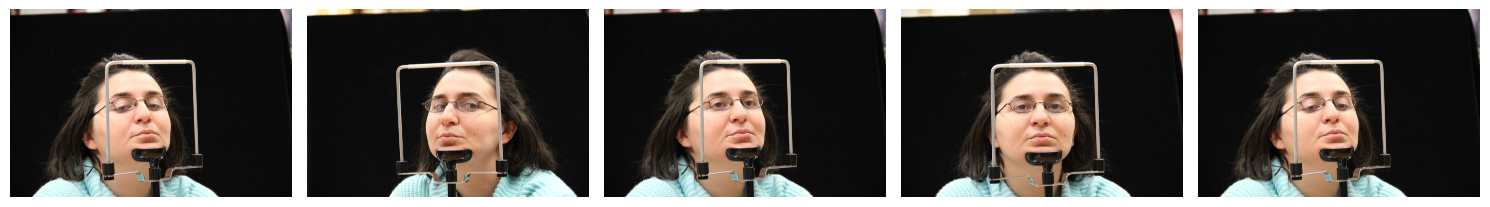

In [80]:
df_subj38 = df[df['subject']=='0037'].reset_index(drop=True)

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i, ax in enumerate(axes):
    img = plt.imread(df_subj38.loc[i, "path"])
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [27]:
img = plt.imread(df.loc[0, "path"])
img.shape

(3456, 5184, 3)

In [28]:
img_30 = plt.imread(df_subj30.loc[17,'path'])
img_30.shape

(3456, 5184, 3)

In [32]:
# do all images have the same shape?
def get_shape_fast(path):
    with Image.open(path) as im:
        w, h = im.size
        return (h, w, 3)  # assume RGB; adjust if you want exact mode

df["img_shape"] = df["path"].apply(get_shape_fast)
df["img_shape"].value_counts()

img_shape
(3456, 5184, 3)    5880
Name: count, dtype: int64

In [33]:
# check aspect ratio consistency
def aspect_ratio(shape):
    h, w = shape[:2]
    return w / h

df["aspect_ratio"] = df["img_shape"].apply(aspect_ratio)
df["aspect_ratio"].describe()

count    5880.0
mean        1.5
std         0.0
min         1.5
25%         1.5
50%         1.5
75%         1.5
max         1.5
Name: aspect_ratio, dtype: float64

<Axes: >

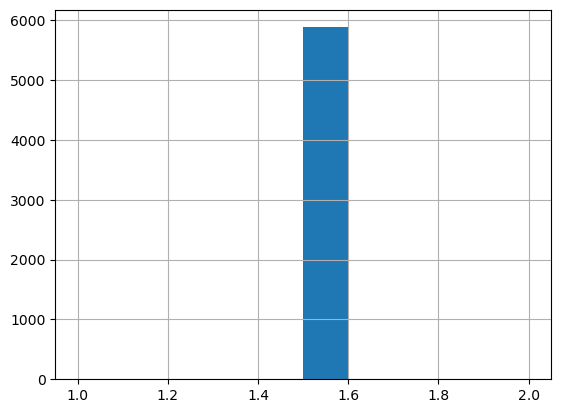

In [35]:
df["aspect_ratio"].hist()

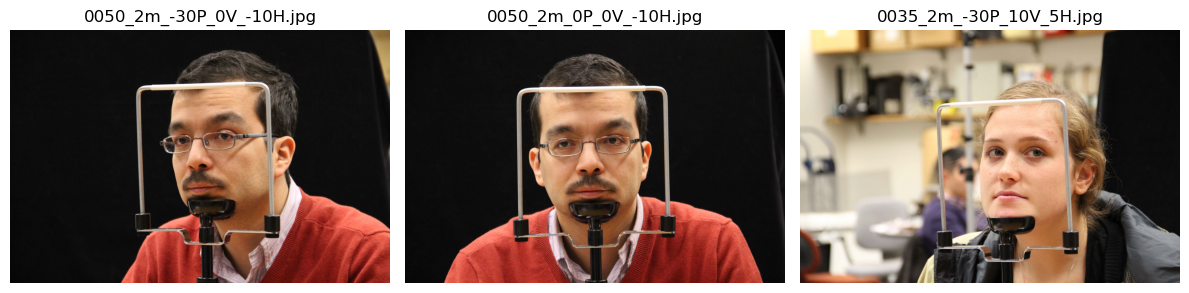

In [36]:
# spot check for json compression artifacts
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, idx in zip(axes, [0, 100, 500]):
    img = plt.imread(df.loc[idx, "path"])
    ax.imshow(img)
    ax.set_title(df.loc[idx, "path"].split("/")[-1])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [38]:
# helper to load img
def load_img_float(path):
    img = plt.imread(path)
    if img.dtype != np.float32:
        img = img.astype(np.float32) / 255.0
    return img

In [42]:
# create sample for faster runs
df_sample = df.sample(500, random_state=42)

In [44]:
# per image pixel stats
def image_stats(path, size=(256, 256)):
    with Image.open(path) as im:
        im = im.resize(size)
        img = np.asarray(im, dtype=np.float32) / 255.0
    return pd.Series({
        "pixel_mean": img.mean(),
        "pixel_var": img.var()
    })

df_sample[["pixel_mean", "pixel_var"]] = (
    df_sample["path"].apply(image_stats)
)

In [45]:
df_sample[["pixel_mean", "pixel_var"]].describe()

,pixel_mean,pixel_var
count,500.000000,500.000000
mean,0.235181,0.063802
std,0.129012,0.022492
min,0.104197,0.023242
25%,0.155667,0.046609
50%,0.186186,0.058775
75%,0.239311,0.081210
max,0.595511,0.136126


In [47]:
# check brightness and contrast distributions
def brightness_contrast(path):
    img = load_img_float(path)
    return pd.Series({
        "brightness": img.mean(),
        "contrast": img.std()
    })

df_sample[["brightness", "contrast"]] = df_sample["path"].apply(brightness_contrast)

<Axes: >

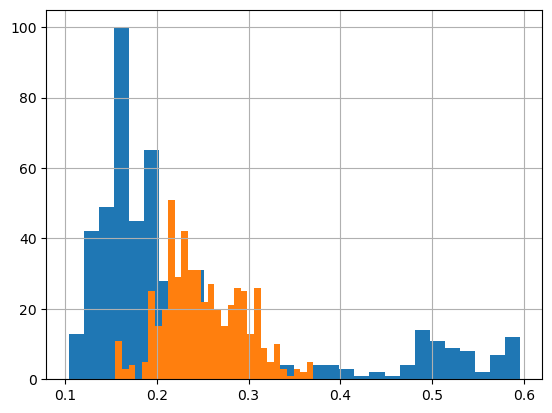

In [48]:
df_sample["brightness"].hist(bins=30)
df_sample["contrast"].hist(bins=30)

In [49]:
# per class pixel statistics
df_sample.groupby("label")[["brightness", "contrast"]].mean()

,brightness,contrast
label,,
down,0.255886,0.256686
left,0.246091,0.252614
right,0.214744,0.247937
straight,0.219674,0.246157
up,0.239554,0.250267


In [50]:
# channel-wise RGB stats
def channel_stats(path):
    img = load_img_float(path)
    return pd.Series({
        "r_mean": img[..., 0].mean(),
        "g_mean": img[..., 1].mean(),
        "b_mean": img[..., 2].mean(),
        "r_std":  img[..., 0].std(),
        "g_std":  img[..., 1].std(),
        "b_std":  img[..., 2].std(),
    })

df_sample = pd.concat([df_sample, df_sample["path"].apply(channel_stats)], axis=1)

In [51]:
df_sample[["r_mean","g_mean","b_mean"]].describe()

,r_mean,g_mean,b_mean
count,500.000000,500.000000,500.000000
mean,0.274534,0.231772,0.199266
std,0.140726,0.131082,0.116072
min,0.124190,0.101839,0.086572
25%,0.187846,0.151582,0.127957
50%,0.224497,0.176970,0.146671
75%,0.276288,0.235379,0.205912
max,0.683896,0.598889,0.525124


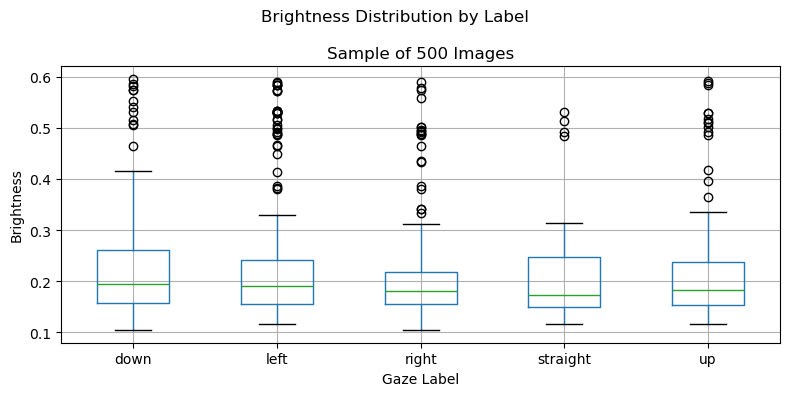

In [71]:
df_sample.boxplot(column="brightness", by="label", figsize=(8,4))

plt.suptitle('Brightness Distribution by Label')  # remove pandas automatic super-title
plt.title('Sample of 500 Images')
plt.xlabel('Gaze Label')
plt.ylabel('Brightness')
plt.tight_layout()
plt.show()

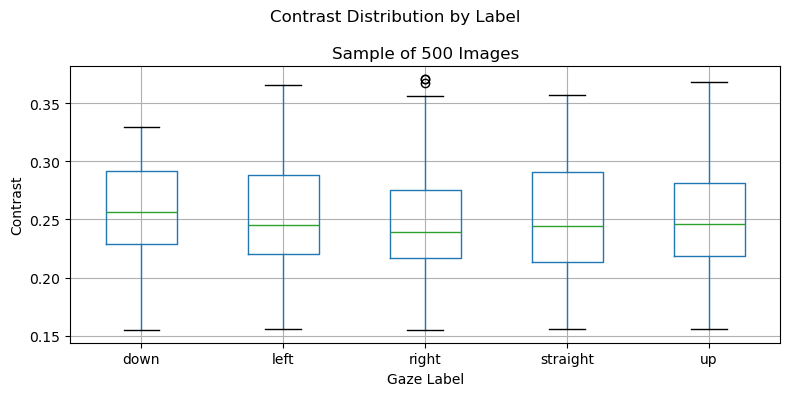

In [72]:
df_sample.boxplot(column="contrast", by="label", figsize=(8,4))

plt.suptitle('Contrast Distribution by Label')  # remove pandas automatic super-title
plt.title('Sample of 500 Images')
plt.xlabel('Gaze Label')
plt.ylabel('Contrast')
plt.tight_layout()
plt.show()

In [53]:
# brightness range per participant
df_sample.groupby("subject")["brightness"].agg(["min", "max", "mean", "std"])

,min,max,mean,std
subject,,,,
0001,0.356477,0.465306,0.389776,0.031105
0002,0.318200,0.581991,0.519028,0.094543
0003,0.486649,0.595528,0.534858,0.051424
0004,0.449262,0.532754,0.501510,0.033387
0005,0.509325,0.590349,0.558704,0.033666
0006,0.515175,0.552156,0.527092,0.012980
0007,0.493912,0.584384,0.536442,0.035724
0008,0.411946,0.492615,0.459844,0.035823
0009,0.133681,0.163271,0.151716,0.009370


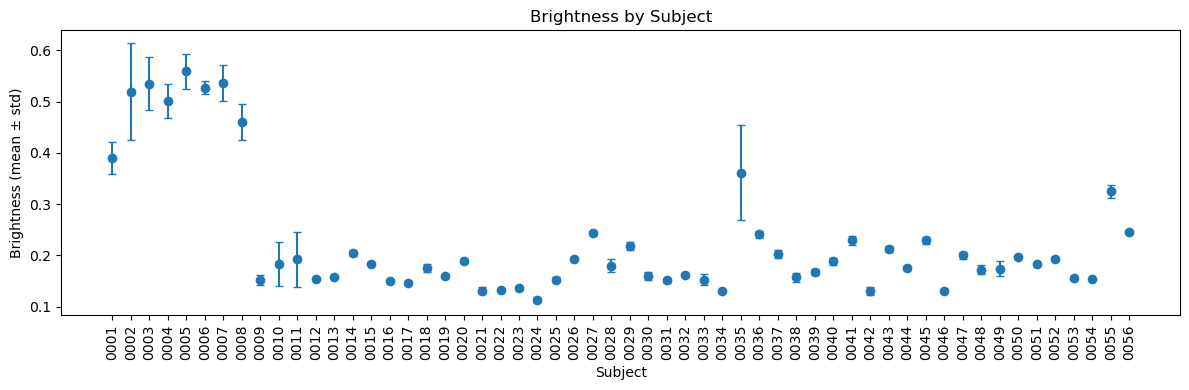

In [63]:
stats = (
    df_sample
    .groupby("subject")["brightness"]
    .agg(["min", "max", "mean", "std"])
    .sort_index()
)

plt.figure(figsize=(12, 4))
plt.errorbar(
    stats.index,
    stats["mean"],
    yerr=stats["std"],
    fmt="o",
    capsize=3
)
plt.xlabel("Subject")
plt.ylabel("Brightness (mean ± std)")
plt.title("Brightness by Subject")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [73]:
# check for participants with extreme lighting
df_sample.groupby("subject")["brightness"].mean().sort_values()

subject
0024    0.113556
0042    0.130419
0046    0.130812
0021    0.131254
0034    0.131342
0022    0.132181
0023    0.137251
0017    0.146787
0016    0.149987
0031    0.151039
0009    0.151716
0025    0.152412
0033    0.152913
0054    0.154684
0012    0.154883
0053    0.155161
0038    0.157089
0013    0.157130
0019    0.159560
0030    0.159826
0032    0.161967
0039    0.168063
0048    0.171842
0049    0.174091
0044    0.175139
0018    0.175163
0028    0.180184
0010    0.183437
0015    0.183574
0051    0.183809
0040    0.188313
0020    0.188923
0011    0.192726
0052    0.192887
0026    0.193068
0050    0.196531
0047    0.199806
0037    0.202256
0014    0.203774
0043    0.211728
0029    0.218367
0045    0.229031
0041    0.229271
0036    0.240760
0027    0.243790
0056    0.245685
0055    0.324620
0035    0.361124
0001    0.389776
0008    0.459844
0004    0.501510
0002    0.519028
0006    0.527092
0003    0.534858
0007    0.536442
0005    0.558704
Name: brightness, dtype: float32

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56]),
 [Text(1, 0, '0001'),
  Text(2, 0, '0002'),
  Text(3, 0, '0003'),
  Text(4, 0, '0004'),
  Text(5, 0, '0005'),
  Text(6, 0, '0006'),
  Text(7, 0, '0007'),
  Text(8, 0, '0008'),
  Text(9, 0, '0009'),
  Text(10, 0, '0010'),
  Text(11, 0, '0011'),
  Text(12, 0, '0012'),
  Text(13, 0, '0013'),
  Text(14, 0, '0014'),
  Text(15, 0, '0015'),
  Text(16, 0, '0016'),
  Text(17, 0, '0017'),
  Text(18, 0, '0018'),
  Text(19, 0, '0019'),
  Text(20, 0, '0020'),
  Text(21, 0, '0021'),
  Text(22, 0, '0022'),
  Text(23, 0, '0023'),
  Text(24, 0, '0024'),
  Text(25, 0, '0025'),
  Text(26, 0, '0026'),
  Text(27, 0, '0027'),
  Text(28, 0, '0028'),
  Text(29, 0, '0029'),
  Text(30, 0, '0030'),
  Text(31, 0, '0031'),
  Text(32, 0, '0032'),
  Text(33, 0, '

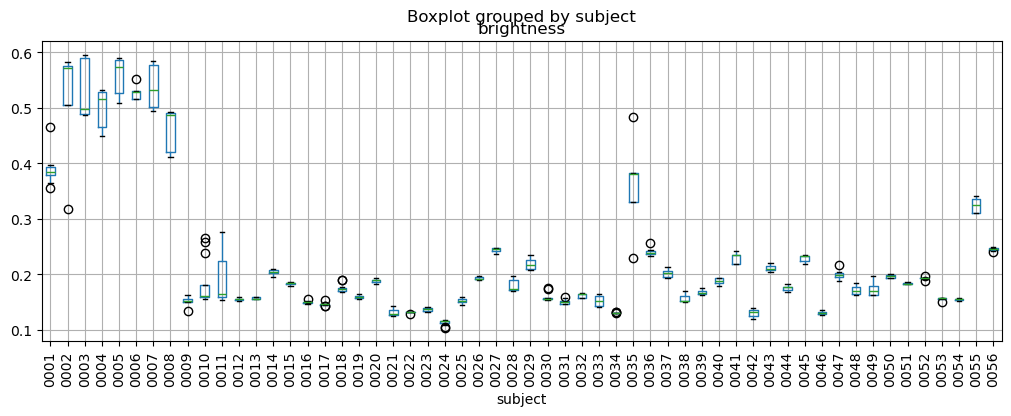

In [74]:
df_sample.boxplot(column="brightness", by="subject", figsize=(12,4))
plt.xticks(rotation=90)